###Libraries

In [ ]:
!pip install pyspark
!pip install pandas

In [ ]:
# Importing Libraries
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.functions import when
from pyspark.sql.types import StringType, FloatType
from pyspark.sql.functions import col

spark = SparkSession.builder.getOrCreate()

### Dataset Preprocessing

In [ ]:
# Membaca dataset yang sudah disiapkan
HeartDisease_df = spark.read.option("inferSchema", "true").csv("heart.csv", header=True)

HeartDisease_df.show(10)

+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+
|age|sex| cp|trestbps|chol|fbs|restecg|thalach|exang|oldpeak|slope| ca|thal|target|
+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+
| 52|  1|  0|     125| 212|  0|      1|    168|    0|    1.0|    2|  2|   3|     0|
| 53|  1|  0|     140| 203|  1|      0|    155|    1|    3.1|    0|  0|   3|     0|
| 70|  1|  0|     145| 174|  0|      1|    125|    1|    2.6|    0|  0|   3|     0|
| 61|  1|  0|     148| 203|  0|      1|    161|    0|    0.0|    2|  1|   3|     0|
| 62|  0|  0|     138| 294|  1|      1|    106|    0|    1.9|    1|  3|   2|     0|
| 58|  0|  0|     100| 248|  0|      0|    122|    0|    1.0|    1|  0|   2|     1|
| 58|  1|  0|     114| 318|  0|      2|    140|    0|    4.4|    0|  3|   1|     0|
| 55|  1|  0|     160| 289|  0|      0|    145|    1|    0.8|    1|  1|   3|     0|
| 46|  1|  0|     120| 249|  0|      0|    144|    0|    0.8|    2|  0|   3|

In [ ]:
HeartDisease_df = HeartDisease_df.withColumnRenamed("cp", "chestPainType")
HeartDisease_df = HeartDisease_df.withColumnRenamed("trestbps", "restingBloodPressure")
HeartDisease_df = HeartDisease_df.withColumnRenamed("chol", "serumCholesterol")
HeartDisease_df = HeartDisease_df.withColumnRenamed("fbs", "fastingBloodSugar")
HeartDisease_df = HeartDisease_df.withColumnRenamed("restecg", "restingElectrocardiographicResult")
HeartDisease_df = HeartDisease_df.withColumnRenamed("thalach", "maximumHeartRateAchieved")
HeartDisease_df = HeartDisease_df.withColumnRenamed("exang", "exerciseInducedAngina")
HeartDisease_df = HeartDisease_df.withColumnRenamed("ca", "majorVesselColor")
HeartDisease_df = HeartDisease_df.withColumnRenamed("thal", "thalassemiaBloodDisorder")
HeartDisease_df = HeartDisease_df.withColumnRenamed("target", "Diagnosis")

In [ ]:
HeartDisease_df.show(10)

+---+---+-------------+--------------------+----------------+-----------------+---------------------------------+------------------------+---------------------+-------+-----+----------------+------------------------+---------+
|age|sex|chestPainType|restingBloodPressure|serumCholesterol|fastingBloodSugar|restingElectrocardiographicResult|maximumHeartRateAchieved|exerciseInducedAngina|oldpeak|slope|majorVesselColor|thalassemiaBloodDisorder|Diagnosis|
+---+---+-------------+--------------------+----------------+-----------------+---------------------------------+------------------------+---------------------+-------+-----+----------------+------------------------+---------+
| 52|  1|            0|                 125|             212|                0|                                1|                     168|                    0|    1.0|    2|               2|                       3|        0|
| 53|  1|            0|                 140|             203|                1|             

In [ ]:
HeartDisease_df = HeartDisease_df.select("age", "sex", "chestPainType",	"restingBloodPressure",	"serumCholesterol",	"fastingBloodSugar",	"restingElectrocardiographicResult", "maximumHeartRateAchieved",	"thalassemiaBloodDisorder",	"Diagnosis")

HeartDisease_df.show(10)

+---+---+-------------+--------------------+----------------+-----------------+---------------------------------+------------------------+------------------------+---------+
|age|sex|chestPainType|restingBloodPressure|serumCholesterol|fastingBloodSugar|restingElectrocardiographicResult|maximumHeartRateAchieved|thalassemiaBloodDisorder|Diagnosis|
+---+---+-------------+--------------------+----------------+-----------------+---------------------------------+------------------------+------------------------+---------+
| 52|  1|            0|                 125|             212|                0|                                1|                     168|                       3|        0|
| 53|  1|            0|                 140|             203|                1|                                0|                     155|                       3|        0|
| 70|  1|            0|                 145|             174|                0|                                1|                 

In [ ]:
HeartDisease_df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- sex: integer (nullable = true)
 |-- chestPainType: integer (nullable = true)
 |-- restingBloodPressure: integer (nullable = true)
 |-- serumCholesterol: integer (nullable = true)
 |-- fastingBloodSugar: integer (nullable = true)
 |-- restingElectrocardiographicResult: integer (nullable = true)
 |-- maximumHeartRateAchieved: integer (nullable = true)
 |-- thalassemiaBloodDisorder: integer (nullable = true)
 |-- Diagnosis: integer (nullable = true)



In [ ]:
HeartDisease_df = HeartDisease_df.na.drop()
HeartDisease_df = HeartDisease_df.filter(col('thalassemiaBloodDisorder') != 0)

In [ ]:
cols = list(HeartDisease_df.columns)
cols.remove("Diagnosis")

assembler = VectorAssembler(inputCols=cols, outputCol="features")
HeartDisease_df = assembler.transform(HeartDisease_df)

# Split data (80% for training, 20% for testing)
(trainingData, testingData) = HeartDisease_df.randomSplit([0.8, 0.2])

trainingData.show(10)
testingData.show(10)

+---+---+-------------+--------------------+----------------+-----------------+---------------------------------+------------------------+------------------------+---------+--------------------+
|age|sex|chestPainType|restingBloodPressure|serumCholesterol|fastingBloodSugar|restingElectrocardiographicResult|maximumHeartRateAchieved|thalassemiaBloodDisorder|Diagnosis|            features|
+---+---+-------------+--------------------+----------------+-----------------+---------------------------------+------------------------+------------------------+---------+--------------------+
| 29|  1|            1|                 130|             204|                0|                                0|                     202|                       2|        1|[29.0,1.0,1.0,130...|
| 29|  1|            1|                 130|             204|                0|                                0|                     202|                       2|        1|[29.0,1.0,1.0,130...|
| 29|  1|            1|  

In [ ]:
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")
scaler_model = scaler.fit(trainingData)
trainingData = scaler_model.transform(trainingData)
testingData = scaler_model.transform(testingData)

### Data Visualization

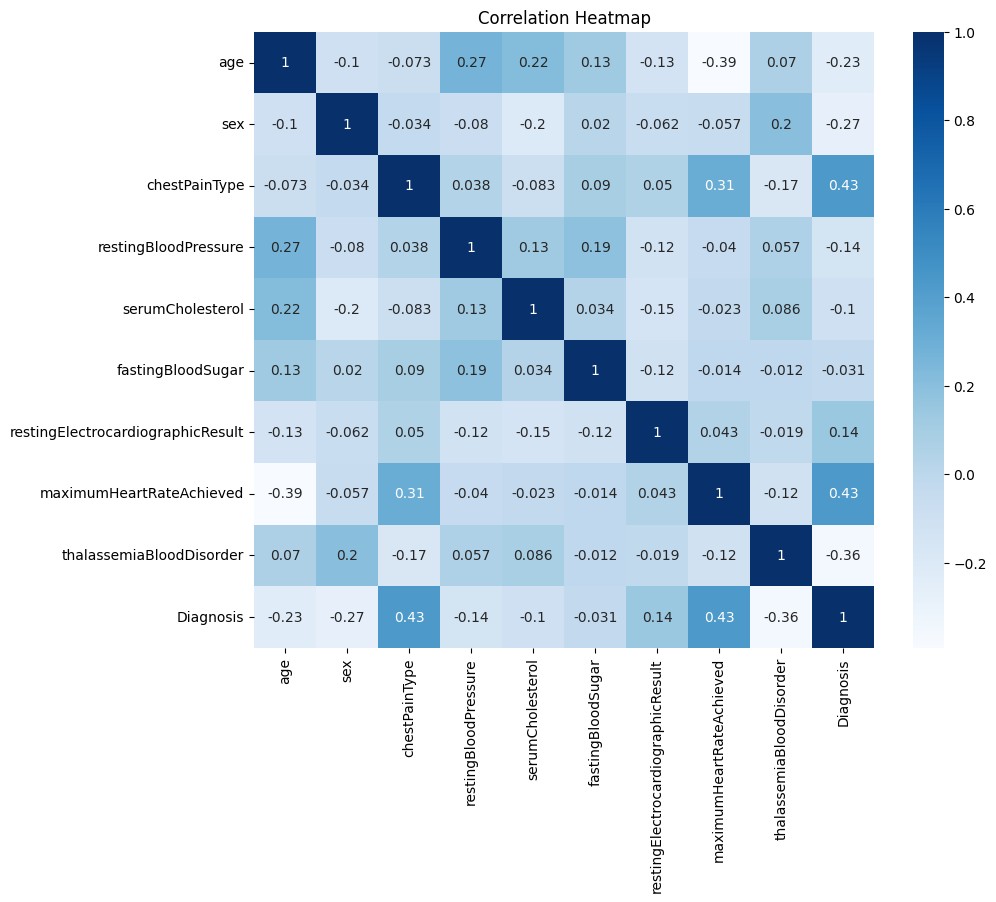

In [ ]:
HeartDisease_pd = HeartDisease_df.select("age", "sex", "chestPainType",	"restingBloodPressure",	"serumCholesterol",	"fastingBloodSugar",	"restingElectrocardiographicResult", "maximumHeartRateAchieved",	"thalassemiaBloodDisorder",	"Diagnosis")
HeartDisease_pd = HeartDisease_pd.toPandas()
correlation_matrix = HeartDisease_pd.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="Blues")  # Use a valid color map name
plt.title("Correlation Heatmap")  # plt.title instead of sns.title
plt.show()  # Ensure to call plt.show() with parentheses


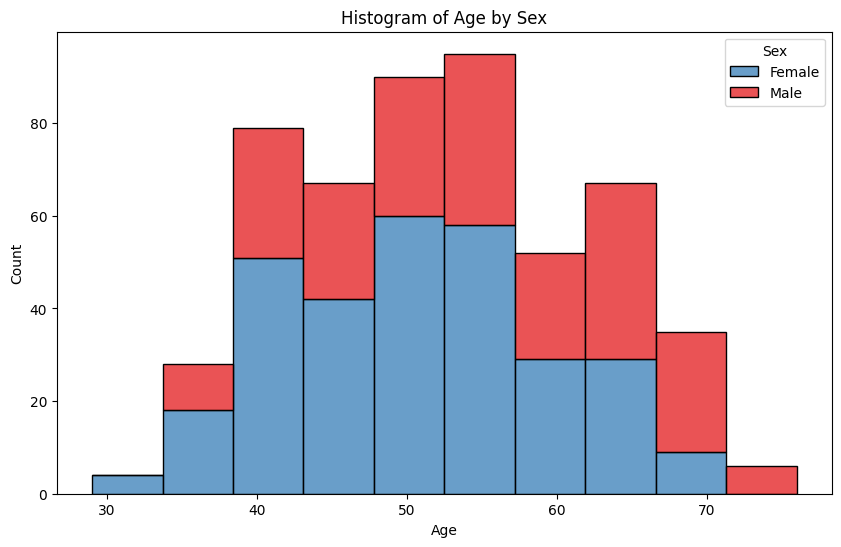

In [ ]:
HeartDisease_temppd = HeartDisease_pd[HeartDisease_pd['Diagnosis'] == 1]

plt.figure(figsize=(10, 6))
sns.histplot(data=HeartDisease_temppd, x='age', hue='sex', multiple='stack', bins=10, palette='Set1', edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Histogram of Age by Sex')
plt.legend(title='Sex', labels=['Female', 'Male'])
plt.show()

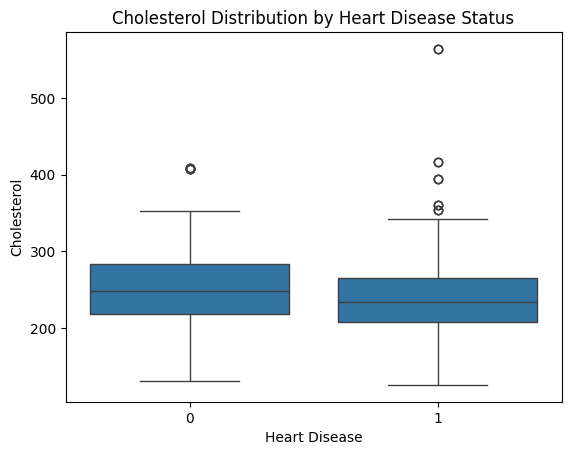

In [ ]:
sns.boxplot(x=HeartDisease_pd['Diagnosis'], y=HeartDisease_pd['serumCholesterol'])
plt.xlabel('Heart Disease')
plt.ylabel('Cholesterol')
plt.title('Cholesterol Distribution by Heart Disease Status')
plt.show()

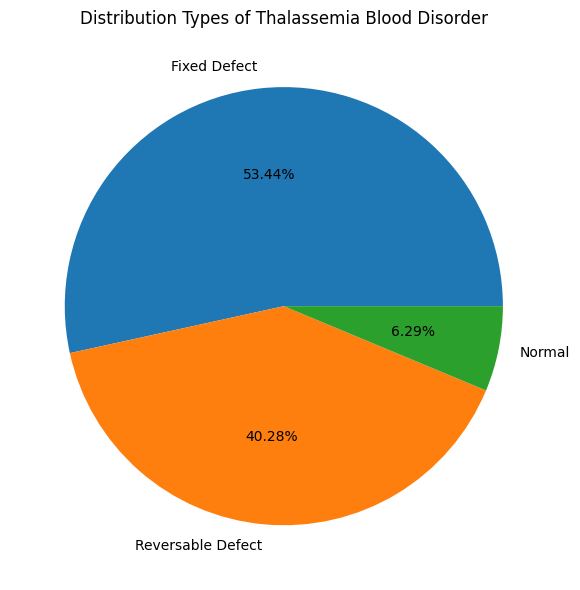

In [ ]:
thalassemiaBloodDisoder_mapping = {
    1: 'Normal',
    2: 'Fixed Defect',
    3: 'Reversable Defect',
}

HeartDisease_pd['thalassemiaBloodDisorder_mapped'] = HeartDisease_pd['thalassemiaBloodDisorder'].replace(thalassemiaBloodDisoder_mapping)
prediction = HeartDisease_pd['thalassemiaBloodDisorder_mapped'].value_counts()

plt.figure(figsize=(10, 6))
plt.pie(prediction.values, labels=prediction.index, autopct="%.2f%%")
plt.title('Distribution Types of Thalassemia Blood Disorder')
plt.tight_layout()
plt.show()

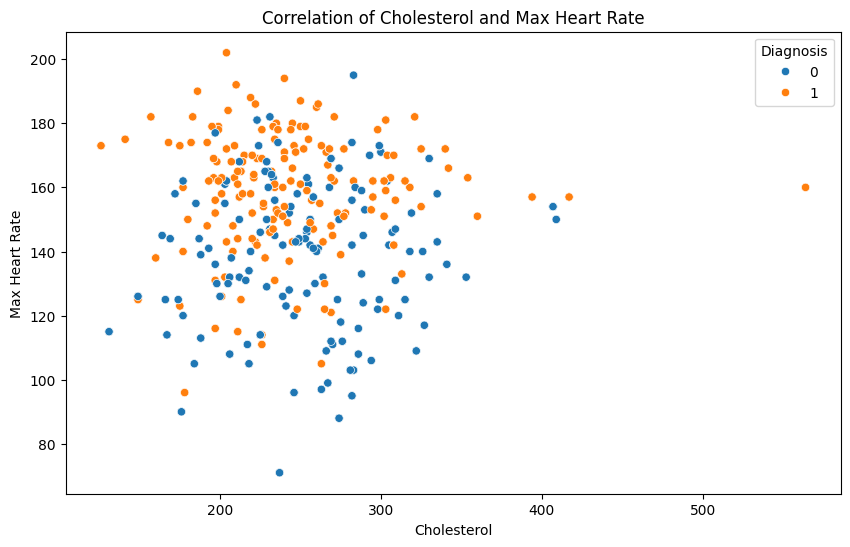

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='serumCholesterol', y='maximumHeartRateAchieved', hue='Diagnosis', data=HeartDisease_pd)
plt.title('Correlation of Cholesterol and Max Heart Rate')
plt.xlabel('Cholesterol')
plt.ylabel('Max Heart Rate')
plt.show()

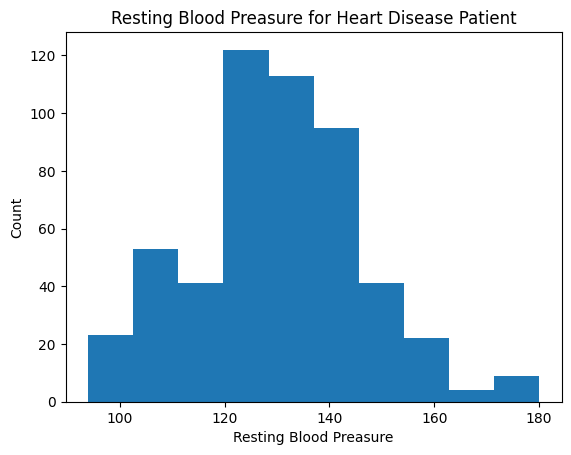

In [ ]:
plt.hist(HeartDisease_temppd['restingBloodPressure'], bins=10)
plt.title('Resting Blood Preasure for Heart Disease Patient')
plt.xlabel('Resting Blood Preasure')
plt.ylabel('Count')
plt.show()

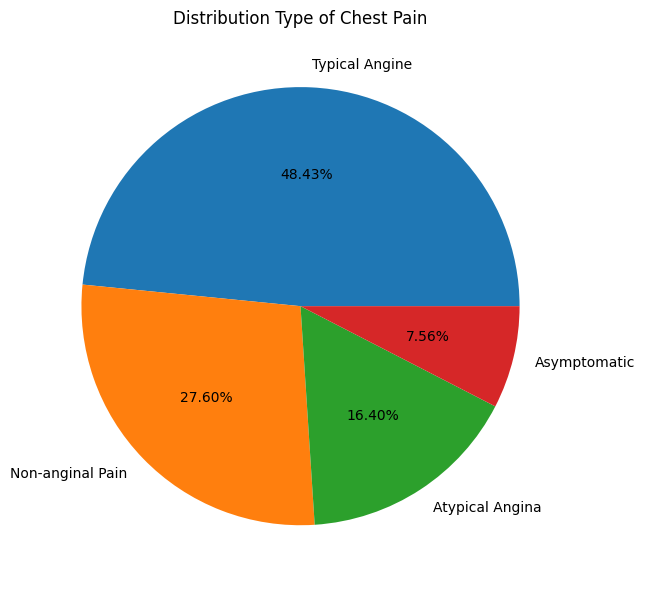

In [ ]:
chestPainTypes_mapping = {
    0: 'Typical Angine',
    1: 'Atypical Angina',
    2: 'Non-anginal Pain',
    3: 'Asymptomatic',
}

HeartDisease_pd['chestPainType_mapped'] = HeartDisease_pd['chestPainType'].replace(chestPainTypes_mapping)
prediction = HeartDisease_pd['chestPainType_mapped'].value_counts()

plt.figure(figsize=(10, 6))
plt.pie(prediction.values, labels=prediction.index, autopct="%.2f%%")
plt.title('Distribution Type of Chest Pain')
plt.tight_layout()
plt.show()

### Modeling

In [ ]:
gbt = GBTClassifier(featuresCol='scaledFeatures', labelCol='Diagnosis')
gbt_model = gbt.fit(trainingData)
gbt_model = gbt.fit(trainingData)

#Gradient Boosting
gbt_predictions = gbt_model.transform(testingData)
gbt_predictions.show()

#Accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="Diagnosis", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(gbt_predictions)
print("Gradient Boosting Accuracy: {:.2f}%".format(accuracy * 100))

+---+---+-------------+--------------------+----------------+-----------------+---------------------------------+------------------------+------------------------+---------+--------------------+--------------------+--------------------+--------------------+----------+
|age|sex|chestPainType|restingBloodPressure|serumCholesterol|fastingBloodSugar|restingElectrocardiographicResult|maximumHeartRateAchieved|thalassemiaBloodDisorder|Diagnosis|            features|      scaledFeatures|       rawPrediction|         probability|prediction|
+---+---+-------------+--------------------+----------------+-----------------+---------------------------------+------------------------+------------------------+---------+--------------------+--------------------+--------------------+--------------------+----------+
| 34|  0|            1|                 118|             210|                0|                                1|                     192|                       2|        1|[34.0,0.0,1.0,118...

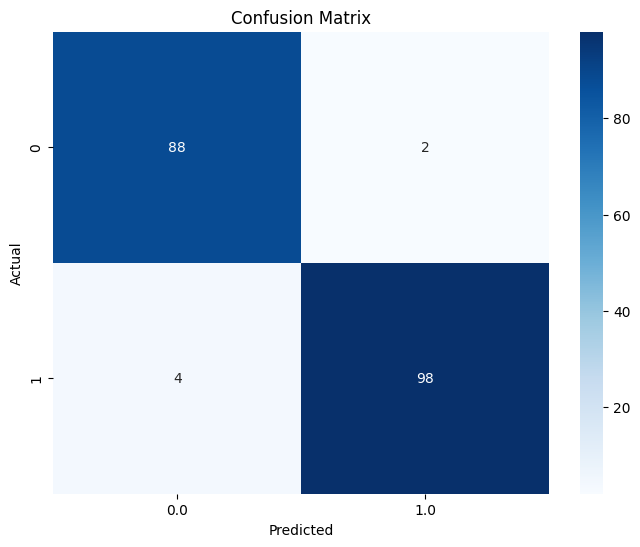

In [ ]:
conf_matrix = gbt_predictions.groupBy("Diagnosis").pivot("prediction").count().fillna(0).orderBy("Diagnosis")
conf_matrix_pd = conf_matrix.toPandas()
# Plotting
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_pd.iloc[:, 1:], annot=True, cmap="Blues", fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()